In [41]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
from scipy import stats
import yfinance as yf
from yahoofinancials import YahooFinancials
from statsmodels.tsa.stattools import adfuller
import pandas_datareader.data as web

In [48]:
# Retrieve data from Github repository
datasource_spx = 'https://raw.githubusercontent.com/y3kiys4/wqu_capstone_june2023_grp3626/main/SPX_1m_Dec2020_Jun2023.csv'

df = pd.read_csv(datasource_spx)

# Set timestamp as index
df = df.set_index(df['Time'])
df.drop(['Time'], axis=1, inplace=True)
df.index = pd.to_datetime(df.index)

# Calculate log return
df['log_ret'] = 100 * np.log(df.Price).diff() # 100 times log return

# Calculate the time difference in mininutes
df['deltaT'] = (df.index.to_series().diff().dt.days.mul(60*24, fill_value=0) +
                df.index.to_series().diff().dt.seconds.div(60, fill_value=0)
               )

# Calculate the cumulative sum of time in minutes
df['cumsum_T'] = df['deltaT'].cumsum()

print(df)

                        Price   log_ret  deltaT   cumsum_T
Time                                                      
2020-12-01 00:00:00  3653.339       NaN     0.0        0.0
2020-12-01 00:01:00  3654.045  0.019323     1.0        1.0
2020-12-01 00:02:00  3654.336  0.007963     1.0        2.0
2020-12-01 00:03:00  3653.945 -0.010700     1.0        3.0
2020-12-01 00:04:00  3653.845 -0.002737     1.0        4.0
...                       ...       ...     ...        ...
2023-06-30 16:09:00  4446.311 -0.011717     1.0  1356009.0
2023-06-30 16:10:00  4445.570 -0.016667     1.0  1356010.0
2023-06-30 16:11:00  4445.332 -0.005354     1.0  1356011.0
2023-06-30 16:12:00  4445.320 -0.000270     1.0  1356012.0
2023-06-30 16:13:00  4444.823 -0.011181     1.0  1356013.0

[836798 rows x 4 columns]


<AxesSubplot:xlabel='Time'>

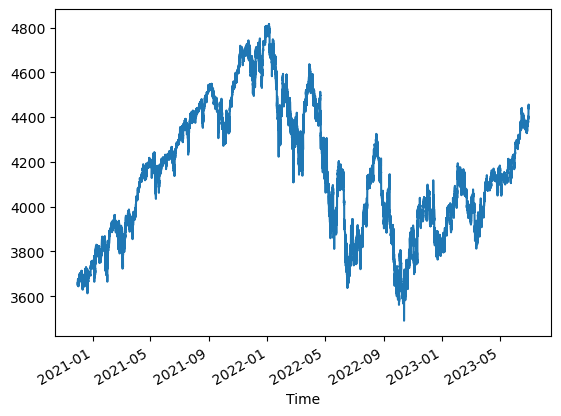

In [43]:
df['Price'].plot()

<AxesSubplot:xlabel='Time'>

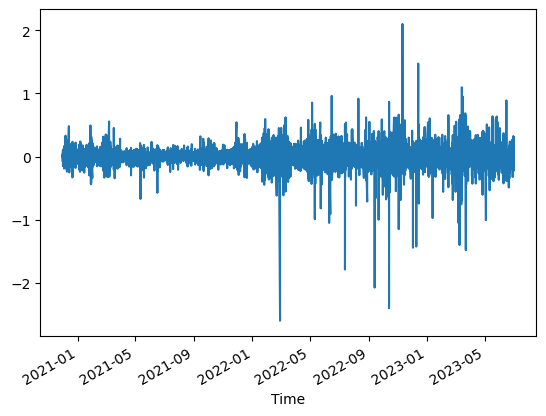

In [44]:
df['log_ret'].plot()

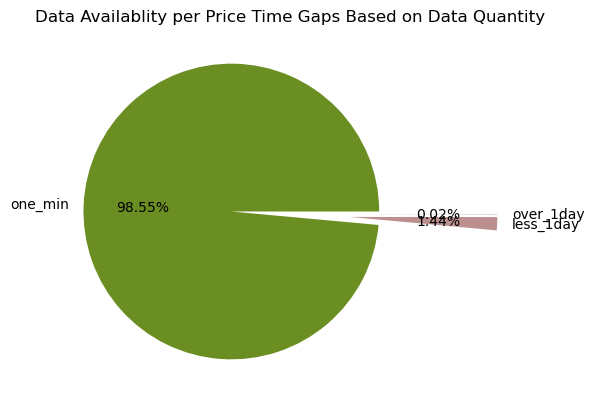

In [45]:
# Categorize data based on quantity of data
one_min_pct_quant = df['deltaT'][df['deltaT'] == 1].count() / df['deltaT'].count()
less_1day_pct_quant = df['deltaT'][(df['deltaT'] > 1) & (df['deltaT'] <= (60 * 24))].count() / df['deltaT'].count()
over_1day_pct_quant = df['deltaT'][df['deltaT'] > 60 * 24].count() / df['deltaT'].count()

labels = 'one_min', 'less_1day', 'over_1day'
sizes = [one_min_pct_quant, less_1day_pct_quant, over_1day_pct_quant]
explode = (0.4, 0.4, 0.4)
colors=['olivedrab', 'rosybrown', 'black']

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%',
        colors=colors, shadow=False, startangle=0)
plt.title('Data Availablity per Price Time Gaps Based on Data Quantity')
plt.show()

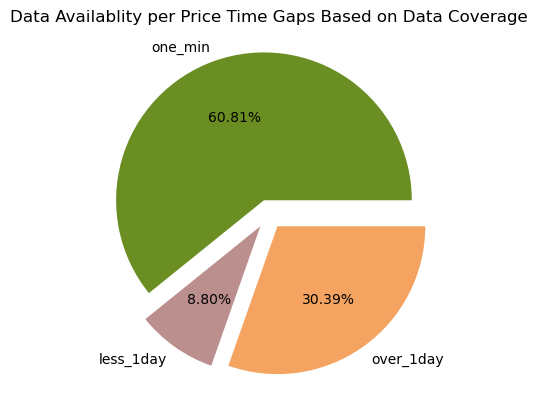

In [47]:
# Categorize data based on coverage of data
one_min_pct_cover = df['deltaT'][df['deltaT'] == 1].sum() / df['deltaT'].count()
less_1day_pct_cover = df['deltaT'][(df['deltaT'] > 1) & (df['deltaT'] <= (60 * 24))].sum() / df['deltaT'].count()
over_1day_pct_cover = df['deltaT'][df['deltaT'] > 60 * 24].sum() / df['deltaT'].count()

labels = 'one_min', 'less_1day', 'over_1day'
sizes = [one_min_pct_cover, less_1day_pct_cover, over_1day_pct_cover]
explode = (0.1, 0.1, 0.1)
colors=['olivedrab', 'rosybrown', 'sandybrown']

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%',
        colors=colors, shadow=False, startangle=0)
plt.title('Data Availablity per Price Time Gaps Based on Data Coverage')
plt.show()

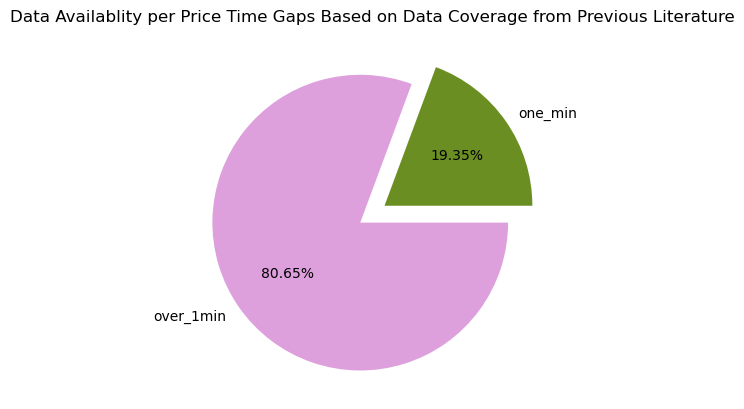

In [33]:
# Categorize data based on coverage of data
one_min_pct_cover_pre_literature = (6.5 * 5) / (24.0 * 7) # suppose one-minute data is available from 9:30 am to 4 pm on weekdays
over_1min_pct_cover_pre_literature = 1 - one_min_pct_cover_pre_literature

labels = 'one_min', 'over_1min'
sizes = [one_min_pct_cover_pre_literature, over_1min_pct_cover_pre_literature]
explode = (0.1, 0.1)
colors=['olivedrab', 'plum']

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%',
        colors=colors, shadow=False, startangle=0)
plt.title('Data Availablity per Price Time Gaps Based on Data Coverage from Previous Literature')
plt.show()

In [34]:
# Focus on the one-minute available data
df_1min = df[df['deltaT'] == 1]
df_1min['log_ret_sq'] = np.square(df_1min['log_ret'])
df_1min

C:\Users\cutef\AppData\Local\Temp\ipykernel_5928\2706122502.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1min['log_ret_sq'] = np.square(df_1min['log_ret'])


,Price,log_ret,deltaT,cumsum_T,log_ret_sq
Time,,,,,
2020-12-01 00:01:00,3654.045,0.019323,1.0,1.0,3.733753e-04
2020-12-01 00:02:00,3654.336,0.007963,1.0,2.0,6.341670e-05
2020-12-01 00:03:00,3653.945,-0.010700,1.0,3.0,1.144941e-04
2020-12-01 00:04:00,3653.845,-0.002737,1.0,4.0,7.490104e-06
2020-12-01 00:05:00,3653.299,-0.014944,1.0,5.0,2.233315e-04
...,...,...,...,...,...
2023-06-30 16:09:00,4446.311,-0.011717,1.0,1356009.0,1.372856e-04
2023-06-30 16:10:00,4445.570,-0.016667,1.0,1356010.0,2.777852e-04
2023-06-30 16:11:00,4445.332,-0.005354,1.0,1356011.0,2.866304e-05


In [35]:
df_1min['log_ret'].mean()

5.757222295233988e-06

In [36]:
df_1min['log_ret'].skew()

-0.8764909132525165

In [37]:
df_1min['log_ret'].kurt()

141.06206295538496

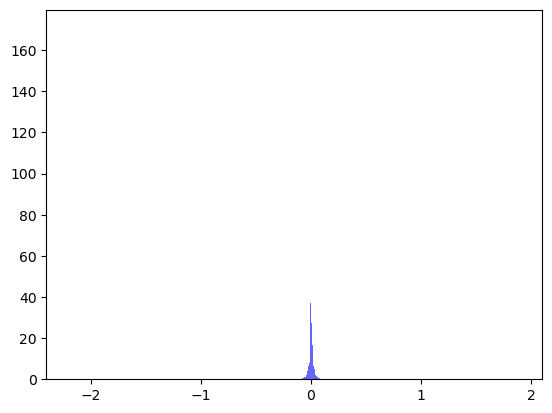

In [38]:
# Plotting the histogram.
plt.hist(df_1min['log_ret'], bins=50000, density=True, alpha=0.6, color='b')
plt.xlim([df_1min['log_ret'].min(), df_1min['log_ret'].max()])
plt.show()

In [15]:
# Augmented Dickey–Fuller test

starttime = time.time()

result = adfuller(df_1min['log_ret'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')  

endtime = time.time()
print('Time spent on ADF test of 1-min daily log return is:', endtime-starttime)

ADF Statistic: -87.69231680346108
n_lags: 0.0
p-value: 0.0
Critial Values:
   1%, -3.4303579308902172
Critial Values:
   5%, -2.8615435053631675
Critial Values:
   10%, -2.5667718657762366
Time spent on ADF test of 1-min daily log return is: 679.9840383529663


In [16]:
# Study on squared minute log return
df_1min['log_ret_sq'].mean()

0.0010090885638312302

In [17]:
df_1min['log_ret_sq'].skew()

296.8438223098629

In [18]:
df_1min['log_ret_sq'].kurt()

114852.5424905033

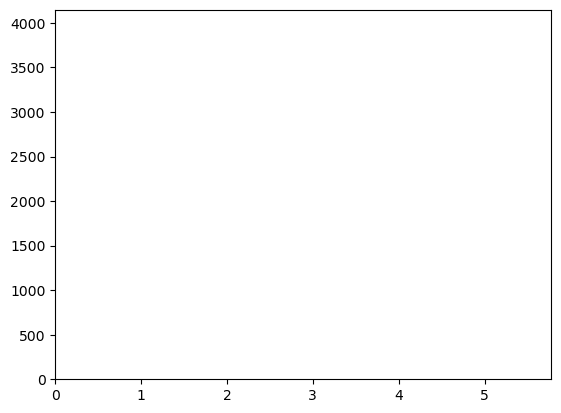

In [39]:
# Plotting the histogram.
plt.hist(df_1min['log_ret_sq'], bins=50000, density=True, alpha=0.6, color='b')
plt.xlim([df_1min['log_ret_sq'].min(), df_1min['log_ret_sq'].max()])
plt.show()

In [20]:
# Augmented Dickey–Fuller test

starttime = time.time()

result = adfuller(df_1min['log_ret_sq'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')  

endtime = time.time()
print('Time spent on ADF test of 1-min daily squared log return is:', endtime-starttime)

ADF Statistic: -61.20257910195778
n_lags: 0.0
p-value: 0.0
Critial Values:
   1%, -3.430357930928692
Critial Values:
   5%, -2.8615435053801725
Critial Values:
   10%, -2.566771865785288
Time spent on ADF test of 1-min daily squared log return is: 667.8482131958008


In [21]:
# # Calculate minutes in 1 day, 1 week and 1 month
# n_min_daily = 60 * 24
# n_min_weekly = n_min_daily * 7
# n_min_monthly = n_min_weekly * 30

# df = df.groupby([df.index.dt.date.year, df.index.dt.date.dayofyear])['log_ret'].\
#var().rename_axis(('year','dayofyear')).reset_index()

In [26]:
# Retrieve daily VIX data from Github repository
datasource_vix = 'https://raw.githubusercontent.com/y3kiys4/wqu_capstone_june2023_grp3626/main/VIX_1d_Dec2020_Jun2023.csv'

vix = pd.read_csv(datasource_vix)

vix.index = vix['DATE']
vix.drop(['DATE'], axis=1, inplace=True)

# Calculate log return
vix['log_ret'] = 100 * np.log(vix.VIX).diff() # 100 times log return
vix.dropna(inplace=True)

print(vix)

              VIX   log_ret
DATE                       
2020-12-02  21.17  1.907545
2020-12-03  21.28  0.518258
2020-12-04  20.79 -2.329556
2020-12-07  21.30  2.423497
2020-12-08  20.68 -2.954002
...           ...       ...
2023-06-26  14.25  5.852157
2023-06-27  13.74 -3.644562
2023-06-28  13.43 -2.282028
2023-06-29  13.54  0.815726
2023-06-30  13.59  0.368596

[657 rows x 2 columns]


Following coding plan:

1. Test if we can forecast realized volatility (RV) if we use rolling average of 5-, 10- and 15-minute;
2. Test if we can forecast VIX by using 5-, 10- and 15-minute RV multifractal dimensions